<a href="https://colab.research.google.com/github/AnhVanGiang/Hand-Fingers-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchcam
!pip install selectivesearch
!pip install torchinfo
!pip install h5py

You should consider upgrading via the 'c:\users\zalgo\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\zalgo\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\zalgo\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\zalgo\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
import plotly
from tqdm.notebook import tqdm
import os
import sys
import numpy as np
from torchvision import transforms as T
from torchvision.io import read_image
import matplotlib.ticker as mtick
import io
from IPython.display import clear_output, display
import PIL.Image as Image
import matplotlib.ticker as mticker
from torchcam.utils import overlay_mask
import zipfile
import seaborn as sns
from torchinfo import summary
#from torch_snippets import *
import sklearn
import torchvision.models as models
import selectivesearch
from torchcam.methods import SmoothGradCAMpp, CAM, ScoreCAM, GradCAMpp
from torch.optim import Adam, SGD
from time import sleep
import h5py as h5
import torch.nn.functional as F
import random
from gtda.images import RadialFiltration, Binarizer, HeightFiltration
from gtda.plotting import plot_heatmap
from gtda.homology import CubicalPersistence

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

#### Reading data

In [116]:
class HandDataset(Dataset):
    def __init__(self, train_p=None, dat=None, train=True, transform=None, one_hot=False, zipf=False):
        
        assert (train_p is not None and dat is None) or (train_p is None or dat is not None)
        
        if train_p is not None:
            self._train_p = train_p
            self._one_hot = one_hot
            self._train = train
            self._zipf = zipf
            self._train_x, self._train_y = self.__get_tensors()
        else:
            self._train_x, self._train_y = dat
        self._transform = transform
    
    def __get_tensors(self):   
        if self._zipf:
            zf = zipfile.ZipFile(self._train_p, "r")
            if self._train:
                train_files = [i for i in zf.namelist() if ("train" in i) and (i.endswith("png"))]
                train_files = train_files[:1000]
            else:
                train_files = [i for i in zf.namelist() if ("test" in i) and (i.endswith("png"))]
                train_files = train_files[:300]
            
            train_x = torch.stack(tuple(torch.from_numpy(self.__read_io_np(zf, f)) for f in train_files))
                
        else:
            train_files = [os.path.join(os.getcwd(), self._train_p, d) for d in os.listdir(self._train_p)]
            train_x = torch.stack(tuple(read_image(f) for f in train_files))
                
        if self._one_hot:  
            train_y = F.one_hot(torch.Tensor([int(f[-6]) for f in train_files]).long(), 6)
        else:
            train_y = torch.Tensor([int(f[-6]) for f in train_files]).long()
            
        return train_x, train_y
            
    
    def __read_io_np(self, zf, f):
        return np.array(Image.open(io.BytesIO(bytearray(zf.read(f)))))
        
        return train_x, train_y
    
    def __len__(self):
        return len(self._train_x)
    
    def __getitem__(self, idx):
        if self._transform is not None:
            return torch.squeeze(self._transform(self._train_x[idx])), self._train_y[idx]
        return self._train_x[idx], self._train_y[idx]
    
  

In [117]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [131]:
def get_data(dtype, one_hot, zip_p=None):
    assert dtype in ("h5", "zip")
    if dtype == "h5":
        transform = T.Compose([
        T.ToPILImage(),
        T.ToTensor(),
        #T.Grayscale(),
        T.Normalize(mean=MEAN, std=STD)])

        train_x = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_x"])
        train_y = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_y"])

        test_x = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_x"])
        test_y = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_y"])

        train_ds = HandDataset(dat=(train_x, train_y), train=True, 
                               transform=transform, one_hot=one_hot, zipf=False)

        test_ds = HandDataset(dat=(test_x, test_y), train=False, 
                              transform=transform, one_hot=one_hot, zipf=False)

        return train_ds, test_ds 

    elif dtype == "zip":

        transform = T.Compose([
        T.ToPILImage(),
        T.ToTensor(),
        #T.Grayscale(),
        T.Lambda(lambda x: x.repeat(3, 1, 1))])
        #T.Normalize(mean=MEAN, std=STD)])

    if zip_p:
        data_p = zip_p
    else:
        data_p = "data.zip"

    train_ds = HandDataset(train_p=data_p, train=True, 
                           transform=transform, one_hot=one_hot, zipf=True)
    
    test_ds = HandDataset(train_p=data_p, train=False, 
                          transform=transform, one_hot=one_hot, zipf=True)
    
    return train_ds, test_ds 

In [132]:
zip_p = "data.zip"

In [133]:
train_ds, test_ds = get_data("zip", False, zip_p)

In [134]:
train_ds[0][0].shape

torch.Size([3, 128, 128])

In [135]:
len(test_ds)

300

#### Visualization

In [136]:
r_images = [random.randint(1, 500) for _ in range(9)]

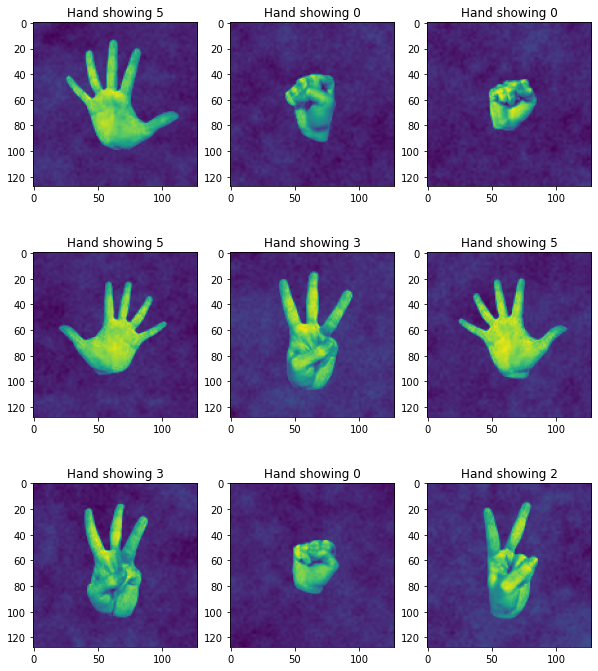

In [138]:
fig, axe = plt.subplots(3, 3, figsize=(10, 12))
c = 0
for i in range(3):
    for j in range(3):
        im = train_ds[r_images[c]][0][0]
        axe[i, j].imshow(im)
        axe[i, j].set_title("Hand showing {}".format(train_ds[r_images[c]][1]))
        c += 1

#### Functions

In [139]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if (r["rect"] in candidates) or (r["size"] < (0.05 * img_area)) or (r["size"] > (1 * img_area)): 
            continue 
        candidates.append(list(r["rect"]))
    return candidates

In [140]:
def get_cam(tensor, model, layer="features"):
    model.eval()
    tensor = tensor.to(device)
    cam = GradCAMpp(model)
    out = model(tensor.unsqueeze(0))
    activation_map = cam(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(T.functional.to_pil_image(tensor), T.functional.to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    return result

In [141]:
def train_batch(x, y, model, opt, loss):
    opt.zero_grad()
    model.train()
    pred = model(x)
    bloss = loss(pred, y)
    bloss.backward()
    opt.step()
    
    return bloss.item()

In [142]:
@torch.no_grad()
def accuracy(x, y, model):
    pred = model(x)
    correct = torch.argmax(pred, dim=1) == y
    return correct.cpu().numpy().tolist()

In [143]:
@torch.no_grad()
def test_loss(x, y, model, loss):
    pred = model(x)
    tloss = loss(pred, y)
    return tloss.item()

In [144]:
def conv_layer(ni, no, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.2)
    ) 

In [145]:
def get_model(name, freeze=True):
    assert name in ("alexnet", "densenet", "resnet", "izolnet")
    
    if name == "alexnet":
        model = models.alexnet(pretrained=True)
        if freeze:
            for l in model.features:
                for p in l.parameters():
                    p.requires_grad = False
        model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=6, bias=True)
    
    elif name == "densenet":
        model = models.densenet121(pretrained=True)
        if freeze:
            for l in model.features:
                for p in l.parameters():
                    p.requires_grad = False
        model.classfier = nn.Linear(in_features=model.classifier.in_features, out_features=6, bias=True)
    
    elif name == "resnet":
        model = models.resnet18(pretrained=True)
        if freeze:
            count = 0
            for c in model.children():
                if count < 10:
                    for p in c.parameters():
                        p.requires_grad = False
                count += 1
        model.fc = nn.Linear(in_features = model.fc.in_features, out_features=6, bias=True)

    elif name == "izolnet":
        model = nn.Sequential(
            conv_layer(3, 64, 3),
            conv_layer(64, 128, 3),
            conv_layer(128, 128, 3),
            conv_layer(128, 128, 3),
            nn.Flatten(),
            nn.Linear(512, 128, bias=True),
            nn.Linear(128, 64, bias=True),
            nn.Linear(64, 6, bias=True),
      )
    
    model = model.to(device)
    return model
            
        

In [146]:
# class IzolNet(nn.Module):
#     def __init__(self):
#         super(IzolNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.max_pool = nn.MaxPool2d(2)
#         self.conv2 = nn.Conv2d(64, 128, 3)
#         self.batch_norm2 = nn.BatchNorm2d(128)
#         self.conv3 = nn.Conv2d(128, 128, 3)
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(512, 5)
        
#     def forward(self, x):
#         x = self.max_pool(self.batch_norm1(F.relu(self.conv1(x))))
#         x = self.max_pool(self.batch_norm2(F.relu(self.conv2(x))))
#         x = self.max_pool(self.batch_norm2(F.relu(self.conv3(x))))
#         x = self.max_pool(self.batch_norm2(F.relu(self.conv3(x))))
#         print(x.shape)
        
#         x = self.flatten(x)
        
#         print(x.shape)
#         x = F.softmax(self.fc(x))
        
#         return x
        

#### Training

In [159]:
model = get_model(name="densenet", freeze=True)

In [160]:
# model = IzolNet().to(device)

In [161]:
train_batchs = 64

In [162]:
test_batchs = 32

In [163]:
train_loader = DataLoader(train_ds, train_batchs, shuffle=True)

In [164]:
test_loader = DataLoader(test_ds, test_batchs, shuffle=True)

In [165]:
opt = Adam(model.parameters(), lr=0.001)

In [166]:
loss = nn.CrossEntropyLoss()

In [167]:
#log = Report(num_epoch)

In [168]:
def train_mod(train_ld, test_ld, model, loss, opt, ne):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    range_ep = range(ne)
    with tqdm(total=len(range_ep), file=sys.stdout) as pbar:
        for ep in range_ep:
            train_ep_loss, train_ep_acc = [], []
            val_ep_acc = []
            c = 0
            len_load = len(train_ld)
            len_tload = len(test_ld)
    #         print("Training...")
            for idx, batch in enumerate(iter(train_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                bloss = train_batch(im, label, model, opt, loss)
                train_ep_loss.append(bloss)

                pos = (ep + (idx + 1) / len_load)

            c_loss = np.mean(train_ep_loss)
            train_loss.append(c_loss)

            #log.record(pos, train_loss=c_loss, end='\r')

            #print("Train loss: {} \n".format(c_loss))

            #print("Testing accuracy on train ...")
            for idx, batch in enumerate(iter(train_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                correct = accuracy(im, label, model)

                train_ep_acc.extend(correct)

                pos = (ep + (idx + 1) / len_load)

            c_acc1 = np.mean(train_ep_acc)
            train_acc.append(c_acc1)

            #log.record(pos, train_acc=c_acc1, end='\r')

            #print("Train acc: {} \n".format(c_acc1))

            for idx, batch in enumerate(iter(test_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                correct = accuracy(im, label, model)
                val_ep_acc.extend(correct)

                pos = (ep + (idx + 1) / len_tload)

            c_acc2 = np.mean(val_ep_acc)
            val_acc.append(c_acc2)
            #log.record(pos, test_acc=c_acc2, end='\r')

                #print("Test acc: {}".format(c_acc2))

            pbar.set_description("Train loss: {:.2f} Train Acc: {:.2f} Test Acc: {:.2f} \n".format(c_loss, c_acc1, c_acc2))
            pbar.update(1)
    return train_loss, train_acc, val_acc

        

In [169]:
ne = 20

In [170]:
train_loss, train_acc, val_acc = train_mod(train_loader, test_loader, model, loss, opt, ne)

  0%|          | 0/20 [00:00<?, ?it/s]

In [92]:
range_ep = list(range(ne))

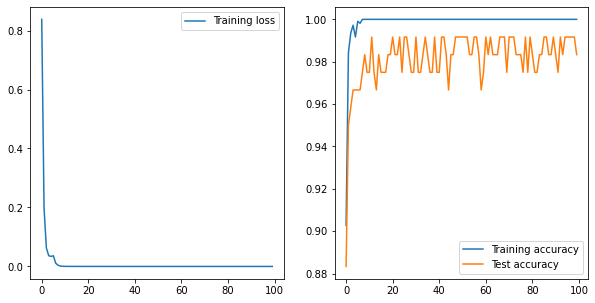

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range_ep, train_loss)
axes[1].plot(range_ep, train_acc)
axes[1].plot(range_ep, val_acc)
axes[0].legend(["Training loss"])
axes[1].legend(["Training accuracy", "Test accuracy"])

### TDA

In [121]:
im = train_ds[200][0]

In [122]:
im_np = im.numpy()[None, :, :]

In [123]:
im_np.shape

(1, 128, 128)

In [124]:
plot_heatmap(im_np[0])

In [125]:
binarizer = Binarizer(threshold=0.4)

In [126]:
im_bin = binarizer.fit_transform(im_np)

In [127]:
binarizer.plot(im_bin)

In [128]:
radial_filtration = RadialFiltration()
im_fil = radial_filtration.fit_transform(im_bin)

In [129]:
radial_filtration.plot(im_fil, colorscale="jet")

In [130]:
cubical_persistence = CubicalPersistence(n_jobs=-1)
im_cub = cubical_persistence.fit_transform(im_fil)

In [131]:
cubical_persistence.plot(im_cub)

In [47]:
train = [train_ds[i] for i in range(1000)]

In [48]:
x_train = np.array([t[0].numpy() for t in train])

In [49]:
y_train = np.array([t[1].numpy() for t in train])

In [50]:
test = [test_ds[i] for i in range(1000)]

In [51]:
x_test = np.array([t[0].numpy() for t in test])

In [52]:
y_test =  np.array([t[1].numpy() for t in test])

In [53]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.diagrams import Scaler
from gtda.diagrams import HeatKernel
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [54]:
train_tda = tda_union.fit_transform(x_train)

In [55]:
train_tda.shape

(1000, 476)

In [172]:
fc_mod = nn.Sequential(
    
    nn.Linear(476, 512),
    nn.Linear(512, 64),
    nn.Linear(64, 6)
)